In [ ]:
# progress bar
!pip install fastprogress

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from fastprogress import master_bar, progress_bar

from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

##### Data Preprocessing

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/character_based_name_analysis/data/combined_train_full_name1.csv')
val_df = pd.read_csv('/content/drive/MyDrive/character_based_name_analysis/data/combined_val_full_name1.csv')
test_df = pd.read_csv('/content/drive/MyDrive/character_based_name_analysis/data/combined_test_full_name1.csv')

In [ ]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(15644774, 3)
(1955596, 3)
(1955598, 3)


In [ ]:
train_df.head()

,full_name,race_code,race
0,Charity Fuentes,1,other
1,Lavonne Howard,5,white
2,Merisney Espinosa,4,hisp
3,Mary Morrissette,5,white
4,Candice Pucci,5,white


In [ ]:
char_vect = CountVectorizer(analyzer='char', lowercase=False)

In [ ]:
char_vect.fit_transform(train_df['full_name'])

<15644774x55 sparse matrix of type '<class 'numpy.int64'>'
	with 169804641 stored elements in Compressed Sparse Row format>

In [ ]:
vocab = list(char_vect.get_feature_names_out())
print(vocab)

[' ', "'", '-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
n_letters = len(vocab)

In [ ]:
classes = train_df[['race_code', 'race']].drop_duplicates().sort_values('race_code').reset_index(drop=True)

categories = list(classes['race'])
n_categories = len(categories)
max_len = train_df['full_name'].str.len().max()

In [ ]:
print(f'categories - {categories}')
print(f'num categories - {n_categories}')
print(f'max name len - {max_len}')

categories - ['other', 'api', 'black', 'hisp', 'white']
num categories - 5
max name len - 47


In [ ]:
# Turning names into Tensors

all_letters = ''.join(vocab)
oob = n_letters + 1

# Find char index from all_letters
def letterToIndex(letter):
  return all_letters.find(letter)

# Turn line into a bag of characters
def lineToTensor(line):
  tensor = torch.ones(50) * oob
  for li, letter in enumerate(line):
    tensor[li] = letterToIndex(letter)
  return tensor

# testing helper functions
print(lineToTensor('Jeff'))
print(lineToTensor('Jeff').size())

tensor([12., 33., 34., 34., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56.])
torch.Size([50])


In [ ]:
# Custom nameDataset
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

class nameDataset(Dataset):
  def __init__(self, data_df, transform=None):
    self.data = data_df
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    name = self.data.iloc[idx, self.data.columns.get_loc('full_name')]
    if self.transform:
      name = self.transform(name)
    label = self.data.iloc[idx, self.data.columns.get_loc('race_code')]
    target = torch.tensor(label, dtype=torch.int64) -1
    return name, target


In [ ]:
train_dataset = nameDataset(train_df, lineToTensor)
val_dataset = nameDataset(val_df, lineToTensor)
test_dataset = nameDataset(test_df, lineToTensor)

In [ ]:
# testing custom dataset
for i in range(3):
  name, label = train_dataset[i]
  print(i, name, label)

0 tensor([ 5., 36., 29., 46., 37., 48., 53.,  0.,  8., 49., 33., 42., 48., 33.,
        47., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56.]) tensor(0)
1 tensor([14., 29., 50., 43., 42., 42., 33.,  0., 10., 43., 51., 29., 46., 32.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56.]) tensor(4)
2 tensor([15., 33., 46., 37., 47., 42., 33., 53.,  0.,  7., 47., 44., 37., 42.,
        43., 47., 29., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56.]) tensor(3)


In [ ]:
# lscpu -> displays info about the CPU architecture
# grep (global regular expression print) -> searches for text patterns or regular expressions matching
num_workers = !lscpu | grep "^CPU(s):" | awk '{print $2}'
num_workers = int(num_workers[0])

In [ ]:
# The Dataset retrieves our dataset’s features and labels one sample at a time.
# While training a model, we typically want to pass samples in “minibatches”,
# reshuffle the data at every epoch to reduce model overfitting,
# and use Python’s multiprocessing to speed up data retrieval.
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# https://pytorch.org/docs/stable/data.html

batch_size=512

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

In [ ]:
# how to iterate through the dataloader (can also use enumerate())
# returns two items: train_features, train_labels
train_features, train_labels = next(iter(train_dataloader))
print(f'train_features: {train_features}')
print(f'train_labels: {train_labels}')

train_features: tensor([[ 6., 37., 29.,  ..., 56., 56., 56.],
        [15., 29., 48.,  ..., 56., 56., 56.],
        [12., 29., 41.,  ..., 56., 56., 56.],
        ...,
        [20., 37., 31.,  ..., 56., 56., 56.],
        [15., 33., 35.,  ..., 56., 56., 56.],
        [ 6., 37., 29.,  ..., 56., 56., 56.]])
train_labels: tensor([4, 3, 2, 4, 4, 2, 4, 4, 4, 3, 4, 4, 2, 4, 3, 3, 3, 0, 4, 3, 4, 2, 4, 4,
        2, 4, 3, 2, 3, 2, 4, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 1, 4, 2, 4,
        4, 2, 4, 2, 2, 2, 2, 4, 4, 3, 4, 3, 3, 3, 2, 4, 4, 4, 2, 4, 4, 4, 4, 2,
        3, 4, 3, 1, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 2, 3, 2, 4, 4, 1, 2,
        3, 3, 1, 4, 4, 4, 4, 4, 3, 4, 3, 2, 4, 4, 4, 4, 4, 4, 1, 4, 3, 4, 4, 2,
        2, 2, 4, 4, 2, 2, 3, 3, 3, 3, 4, 2, 4, 3, 3, 4, 4, 4, 3, 4, 3, 4, 3, 0,
        4, 4, 4, 4, 4, 3, 4, 0, 2, 2, 2, 4, 3, 4, 4, 4, 2, 3, 2, 4, 2, 2, 3, 4,
        1, 1, 4, 4, 2, 3, 4, 4, 1, 4, 4, 4, 2, 4, 4, 4, 3, 2, 2, 4, 2, 2, 4, 4,
        4, 4, 3, 4, 0, 4, 4, 4, 4, 4, 4,

#### Define LSTM Model

In [ ]:
# set seed for reproducable results
torch.manual_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class lstmnet(nn.Module):
  def __init__(self, input_size, output_size, hidden_size, num_layers=1):
    super().__init__()

    # embedding layer (returns a vector of input_size x 1 x hidden_size)
    self.embedding = nn.Embedding(input_size, hidden_size)

    # lstm layer params: input_size, output_size, num_layers
    self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)

    self.out = nn.Linear(hidden_size, output_size)

    # used to convert the output from a linear layer into a categorical probability distribution
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, x, h):

    x = x.to(device)

    # embedding layer
    embedding = self.embedding(x.type(torch.IntTensor).to(x.device))

    # run through the RNN layer
    y, h = self.lstm(embedding, h)

    # Getting the output of the last time step
    y = y[:, -1, :]

    # output the linear layer
    y = self.out(y)
    y = self.softmax(y)

    return y, (h[0].detach(), h[1].detach()) # just the numerical values for h


In [ ]:
hidden_size = 256
seq_len = 50
num_layers = 2

In [ ]:
# model instance
rnn = lstmnet(n_letters+2, n_categories, hidden_size, num_layers=num_layers).to(device)
rnn

lstmnet(
  (embedding): Embedding(57, 256)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  (out): Linear(in_features=256, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

#### Test model with sample data

In [ ]:
x = lineToTensor('Jeff Bezos')

print(x)
print('x shape : ', x.shape)
print('x w batch : ', x.unsqueeze(0).shape)

y, h = rnn(x.unsqueeze(0), None)

print(y.shape)
print(y)
print(torch.argmax(y))
print(f'model predicted w/o train - {categories[torch.argmax(y).item()]}')

tensor([12., 33., 34., 34.,  0.,  4., 33., 54., 43., 47., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56.])
x shape :  torch.Size([50])
x w batch :  torch.Size([1, 50])
torch.Size([1, 5])
tensor([[-1.6279, -1.6090, -1.6167, -1.5790, -1.6152]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
tensor(3, device='cuda:0')
model predicted w/o train - hisp


#### Training

In [ ]:
epochs = 100
lr = 0.0005

# loss function and optimizer
lossfun = nn.NLLLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60, eta_min=1e-5)

mb = master_bar(range(epochs))
mb.names = ['Training loss', 'Validation loss']

In [25]:
losses = np.zeros(epochs)
val_losses = np.zeros(epochs)
epoch_list = []

count=0
val_mloss = np.inf


# loop over epochs
for epoch in mb:

  epoch_list.append(epoch)

  # initialize loss for this epoch and hidden state
  total_loss = 0
  hidden_state = None
  rnn.train()

  for batch in progress_bar(train_dataloader, parent=mb):
    x = batch[0].to(device)
    y = batch[1].to(device)

    # forward pass
    output, hidden_state = rnn(x, None)

    # compute loss
    loss = lossfun(output, y)
    total_loss += loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # decay lr
  scheduler.step()

  # Calculate average loss for the epoch
  epoch_loss = total_loss / len(train_dataloader)
  losses[epoch] = epoch_loss

  # validation loss calulations
  rnn.eval()
  val_loss = 0
  for batch in progress_bar(val_dataloader, parent=mb):
    x = batch[0].to(device)
    y = batch[1].to(device)

    # forward pass
    output, hidden_state = rnn(x, None)

    # compute loss
    loss = lossfun(output, y)
    val_loss += loss.item()

  # Calculate average loss for the epoch
  val_mean_loss = val_loss / len(val_dataloader)
  val_losses[epoch] = val_mean_loss
  mb.write(f'\nEpoch {epoch}: Training loss {epoch_loss:.6f}, Validation loss {val_mean_loss:.6f}') # Update progress bar comment

  if val_mean_loss < val_mloss:
    print(f'\nValidation loss decreased ({val_mloss:.6f} --> {val_mean_loss:.6f}).  Saving model ...')
    val_mloss = val_mean_loss
    count = 0
    # save model
    torch.save(rnn.state_dict(), 'lstm_FullName_pytorch_min_val.pt')
  else:
    count += 1
    if count == 5:
      break


In [26]:
torch.save(rnn.state_dict(), 'lstm_FullName_pytorch_combined.pt')

Text(0, 0.5, 'loss')

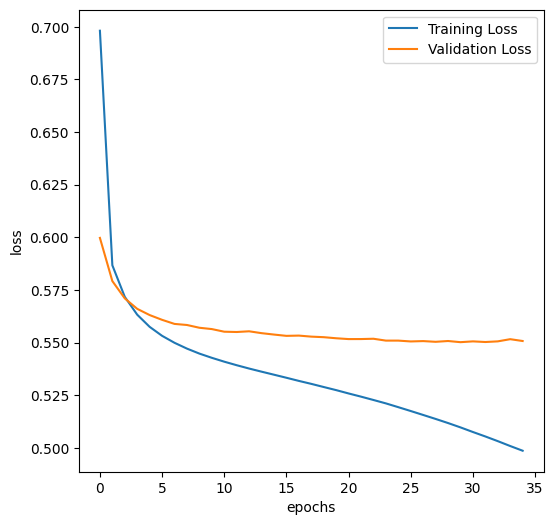

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(epoch_list, losses[:35], label='Training Loss')
ax.plot(epoch_list, val_losses[:35], label='Validation Loss')
ax.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

In [31]:
# last epoch loss
print(f'Training loss: {losses[34]}')
print(f'Validation loss: {val_losses[34]}')

Training loss: 0.498597294919262
Validation loss: 0.550725565691149


#### Testing

In [32]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

test_loss = 0.0

class_correct = [0.0 for _ in range(n_categories)]
class_total = [0.0 for _ in range(n_categories)]

actual = []
predictions = []

rnn.eval()

pbar = progress_bar(test_dataloader)
for batch in pbar:
  x = batch[0].to(device)
  y = batch[1].to(device)

  output, hidden_state = rnn(x, None)

  # sum up batch loss
  loss = lossfun(output, y)
  test_loss += loss.item()

  # convert output probabilities to predicted class
  pred = torch.argmax(output, dim=1)

  # compare predictions to true label
  correct_tensor = pred.eq(y.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

  # calculate test accuracy
  for i in range(y.shape[0]):
    l = y[i].detach()
    class_correct[l] += correct[i].item()
    class_total[l] += 1

    actual.append(categories[l])
    predictions.append(categories[pred[i].detach()])

# classification report
print(classification_report(actual, predictions))


              precision    recall  f1-score   support

         api       0.73      0.66      0.70     58128
       black       0.77      0.70      0.74    392277
        hisp       0.87      0.91      0.89    488746
       other       0.44      0.07      0.12     77037
       white       0.82      0.89      0.85    939140

    accuracy                           0.82   1955328
   macro avg       0.73      0.65      0.66   1955328
weighted avg       0.80      0.82      0.80   1955328



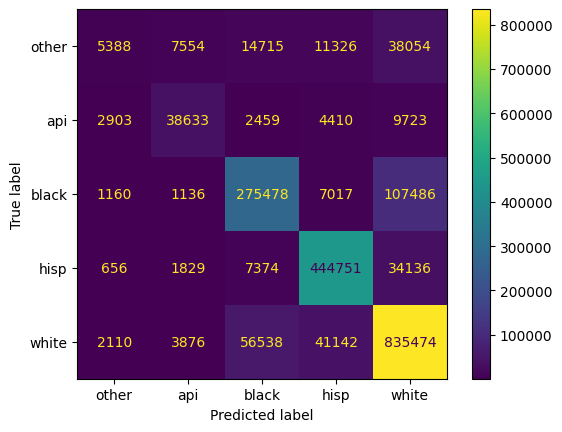

In [33]:
# plot confusion matrix

cm = confusion_matrix(actual, predictions, labels=categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot()
plt.show()

In [34]:
print(f'Test loss: {test_loss / len(test_dataloader)}')

Test loss: 0.552714985354654


In [35]:
for i in range(len(categories)):
  print(f'Test Accuracy of {categories[i]}: {100 * class_correct[i] / class_total[i]}% ({class_correct[i]}/{class_total[i]})')
  print()
print(f'Test Accuracy of all: {100 * np.sum(class_correct) / np.sum(class_total)}% ({np.sum(class_correct)}/{np.sum(class_total)})')

Test Accuracy of other: 6.994041824058569% (5388.0/77037.0)

Test Accuracy of api: 66.46194605009634% (38633.0/58128.0)

Test Accuracy of black: 70.22537645592273% (275478.0/392277.0)

Test Accuracy of hisp: 90.99839180269505% (444751.0/488746.0)

Test Accuracy of white: 88.96160316885661% (835474.0/939140.0)

Test Accuracy of all: 81.81358830845771% (1599724.0/1955328.0)
